<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [K3IMDB5] - Sentiment analysis with a RNN network
<!-- DESC --> Still the same problem, but with a network combining embedding and RNN, using Keras 3 and PyTorch
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Use of a model combining embedding and LSTM

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://keras.io/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a Embedding/LSTM model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import keras.datasets.imdb as imdb

import json,re
import numpy as np

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('K3IMDB5')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : K3IMDB5
Run dir              : ./run/K3IMDB5
Datasets dir         : /data/datasets-fidle
Start time           : 10/07/24 14:51:21
Hostname             : ebf2030c9b9e (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/K3IMDB5/figs (False)
keras                : 3.0.5
numpy                : 1.26.4
sklearn              : 1.4.1.post1
yaml                 : 6.0.1
matplotlib           : 3.8.3
pandas               : 2.2.1
torch                : 2.2.1+cpu


## Step 2 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.  
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).  
`hide_most_frequently` is the number of ignored words, among the most common ones  
`review_len` is the review length  
`dense_vector_size` is the size of the generated dense vectors  
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch\
`scale` is a dataset scale factor - note a scale=1 need a training time > 10'

In [3]:
vocab_size           = 10000
hide_most_frequently = 0

review_len           = 256
dense_vector_size    = 32

epochs               = 10
batch_size           = 128

fit_verbosity        = 1
scale                = 0.2

Override parameters (batch mode) - Just forget this cell

In [4]:
fidle.override('vocab_size', 'hide_most_frequently', 'review_len', 'dense_vector_size')
fidle.override('batch_size', 'epochs', 'fit_verbosity', 'scale')

## Step 3 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://keras.io/api/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 3.1 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://keras.io/api/datasets/imdb/)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/)  

**Load dataset :**

In [5]:
# ----- Retrieve x,y
#
start_char = 1      # Start of a sequence (padding is 0)
oov_char   = 2      # Out-of-vocabulary
index_from = 3      # First word id

(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size, 
                                                       skip_top   = hide_most_frequently,
                                                       start_char = start_char, 
                                                       oov_char   = oov_char, 
                                                       index_from = index_from)

# ---- Rescale
#
n1 = int(scale * len(x_train))
n2 = int(scale * len(x_test))
x_train, y_train = x_train[:n1], y_train[:n1]
x_test,  y_test  = x_test[:n2],  y_test[:n2]

# ---- About
#
print("Max(x_train,x_test)  : ", fidle.utils.rmax([x_train,x_test]) )
print("Min(x_train,x_test)  : ", fidle.utils.rmin([x_train,x_test]) )
print("Len(x_train)         : ", len(x_train))
print("Len(x_test)          : ", len(x_test))

Max(x_train,x_test)  :  9999
Min(x_train,x_test)  :  1
Len(x_train)         :  5000
Len(x_test)          :  5000


### 3.2 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [6]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#      Shift the dictionary from +3
#      Add <pad>, <start> and <unknown> tags
#      Create a reverse dictionary : {index:word}
#
word_index = imdb.get_word_index()
word_index = {w:(i+index_from) for w,i in word_index.items()}
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )
index_word = {index:word for word,index in word_index.items()} 

# ---- A nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [9]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
fidle.utils.subtitle('Review example :')
print(x_train[12])
fidle.utils.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88588
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 9667, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]


<br>**After translation :**

<start> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the <unknown> feeling all the way from the beginning of the film to the very end look i don't need a 10 page <unknown> or a sign with big letters explaining a plot to me but dark floors takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary or thrilling but if you have an hour and a half to kill and or you want to end up feeling frustrated and confused rent this winner


## Step 4 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [11]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

fidle.utils.subtitle('After padding :')
print(x_train[12])
fidle.utils.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   13  119  954  189 1554   13   92  459   48    4  116    9 1492
 2291   42  726    4 1939  168 2031   13  423   14   20  549   18    4
    2  547   32    4   96   39    4  454    7    4   22    8    4   55
  130  168   13   92  359    6  158 1511    2   42    6 1913   19  194
 4455 4121    6  114    8   72   21  465 9667  304    4   51    9   14
   20   44  155    8    6  226  162  616  651   51    9   14   20   44
   10   10   14  218 4843  629   42 3017   21   48   25   28   35  534
    5    6  320    8  516    5   42   25  181    8  130   56  547 3571
    5 1471  851   14 2286    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the <unknown> feeling all the way from the beginning of the film to the very end look i don't need a 10 page <unknown> or a sign with big letters explaining a plot to me but dark floors takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary or thrilling but if you have an hour and a half to kill and or you want to end up feeling frustrated and confused rent this winner <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

## Step 5 - Build the model

More documentation about this model functions :
 - [Embedding](https://keras.io/api/layers/core_layers/embedding/)
 - [GlobalAveragePooling1D](https://keras.io/api/layers/pooling_layers/global_average_pooling1d)

In [12]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim = vocab_size, output_dim = dense_vector_size))
model.add(keras.layers.GRU(50))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss      = 'binary_crossentropy',
              metrics   = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 6 - Train the model
### 6.1 - Add Callbacks

In [13]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model.keras'

savemodel_callback = keras.callbacks.ModelCheckpoint( filepath=save_dir, monitor='val_accuracy', mode='max', save_best_only=True)

### 6.2 - Train it
Note : With a scale=0.2, batch_size=128, epochs=10 => Need 4' on a cpu laptop

In [14]:
history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.4976 - loss: 0.6935 - val_accuracy: 0.4920 - val_loss: 0.6931
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5099 - loss: 0.6928 - val_accuracy: 0.4858 - val_loss: 0.6942
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5141 - loss: 0.6921 - val_accuracy: 0.5236 - val_loss: 0.6920
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5152 - loss: 0.6909 - val_accuracy: 0.4912 - val_loss: 0.6944
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5157 - loss: 0.6886 - val_accuracy: 0.4946 - val_loss: 0.6939
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5372 - loss: 0.6826 - val_accuracy: 0.4998 - val_loss: 0.6977
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5656 - loss: 0.6730 - val_accuracy: 0.5442 - val_loss: 0.6898
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5740 - loss: 0.6558 - val_accuracy: 0.5604 - val_lo

### 6.4 - Training history

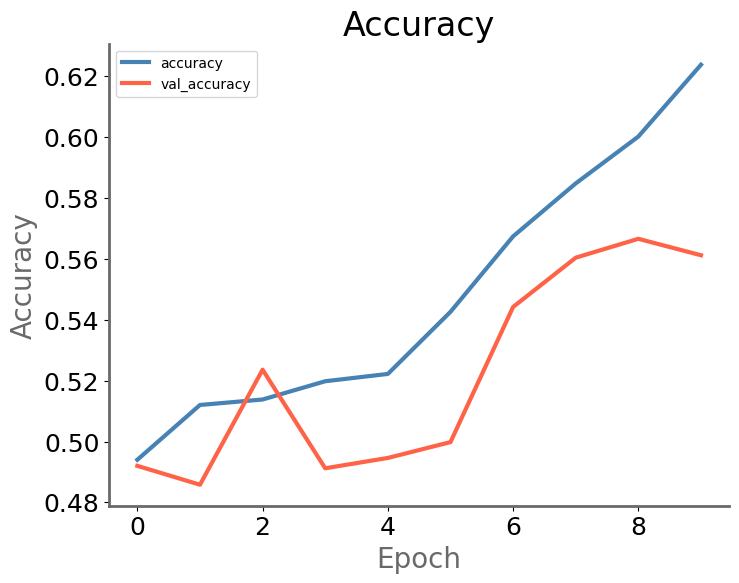

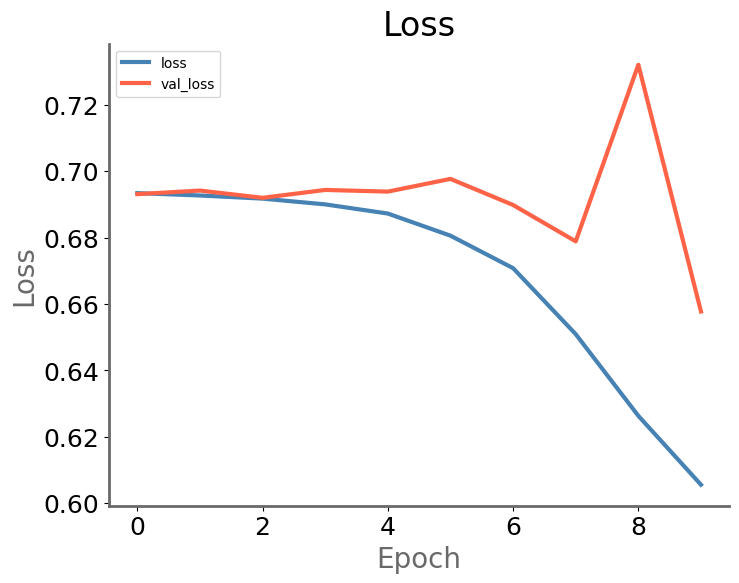

In [15]:
fidle.scrawler.history(history, save_as='02-history')

## Step 7 - Evaluation
Reload and evaluate best model

x_test / loss      : 0.7297
x_test / accuracy  : 0.5666


#### Accuracy donut is :

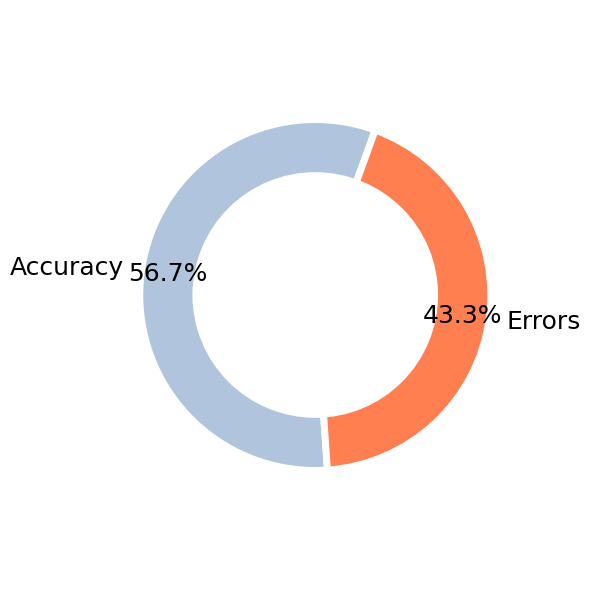

157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step


#### Confusion matrix is :

,0,1
0,0.95,0.05
1,0.84,0.16


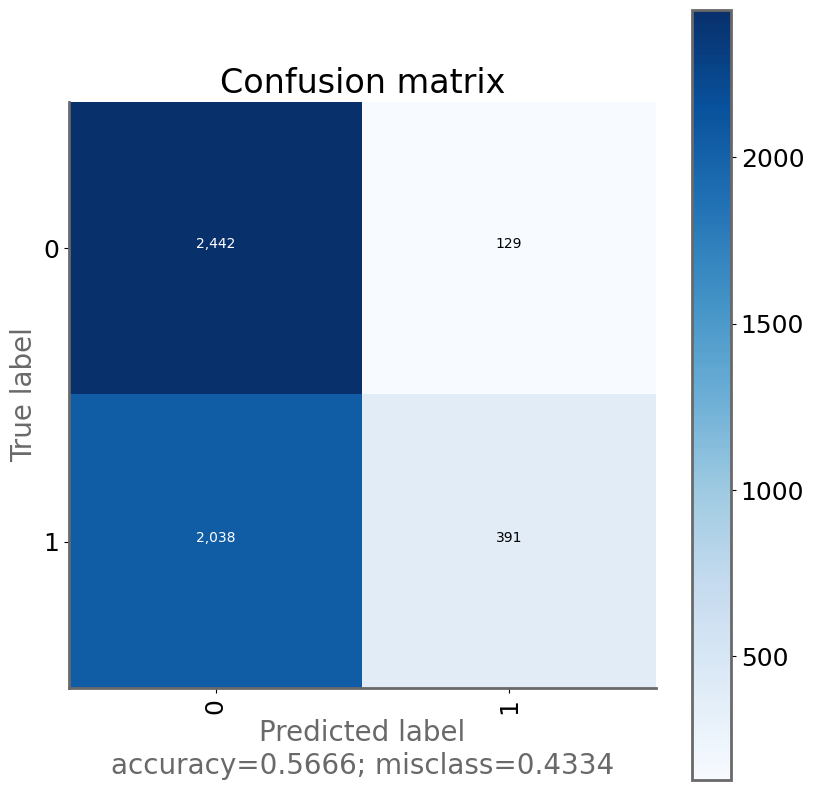

In [20]:
model = keras.models.load_model(f'{run_dir}/models/best_model.keras')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
fidle.scrawler.donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test, verbose=fit_verbosity)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

fidle.scrawler.confusion_matrix_txt(y_test,y_pred,labels=range(2))
fidle.scrawler.confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [17]:
fidle.end()

**End time :** 10/07/24 15:17:42  
**Duration :** 00:26:21 347ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>